This notebook tries to recreate the SpO2 algorithm from https://github.com/XDjackieXD/TomoStrap/blob/master/microcontroller/source/max_spo2.c using data collected with a card10 badge

It tries to plot as many graphs as possible.

While the original algorithm works on a stream of samples, this notebook performs all operations on the whole dataset to make them easier to understand.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import math

In [2]:
# The dataset collected with the card10 badge contains red and infrared data at 100 samples per second
lines = open('spo2-data-88-100').readlines()

In [3]:
# A negative sign to the signals look more like shown in https://www.maximintegrated.com/en/design/technical-documents/app-notes/7/7082.html
data = [(-int(x[0]), -int(x[1])) for x in [y.strip().split(',') for y in lines]]
data_red_with_dc = numpy.array([x[0] for x in data])
data_ir_with_dc = numpy.array([x[1] for x in data])

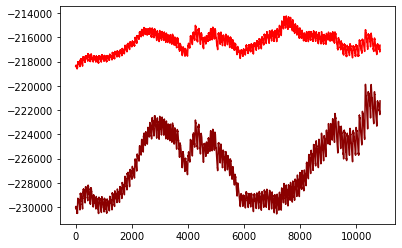

In [4]:
# Let's plot the data to get a feel for it.
# Luckily both red and infrared are close to each other in terms of DC offset.
plt.plot(data_red_with_dc, color='red')
plt.plot(data_ir_with_dc, color='darkred')

## DC offset removal

Goal is to remove the large (around -234000) DC offset from the signals and flatten them as much as possible.
The algorithm has to converge fairly quick to account for the finger changing position / pressure.

In [5]:
def spo2_dcRemoval(data):
    prev_w = 0
    filtered = []

    for sample in data:
        w = sample + prev_w * 0.95
        filtered.append(w - prev_w)
        prev_w = w

    return numpy.array(filtered)


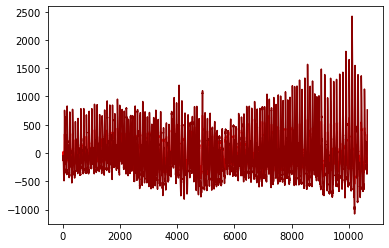

In [6]:
data_red = spo2_dcRemoval(data_red_with_dc)
data_ir = spo2_dcRemoval(data_ir_with_dc)
plt.plot(data_red[200:], color='red')
plt.plot(data_ir[200:], color='darkred')

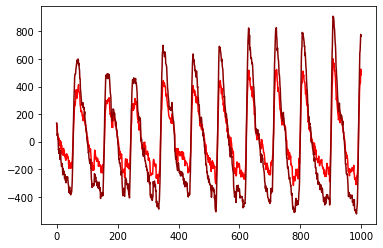

In [7]:
# Red and infrared are now without DC offset and directly on top of each other
plt.plot(data_red[6000:7000], color='red')
plt.plot(data_ir[6000:7000], color='darkred')

## Pulse detection

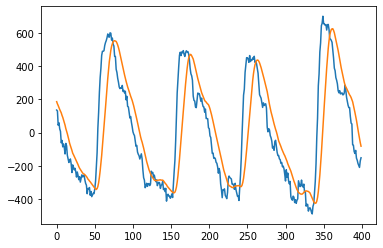

In [8]:
# spo2_mean extracted from TomoStrap
# Calculates a moving average over 15 samples
def spo2_mean(ir, MEAN_FILTER_SIZE=15):
    ret = numpy.zeros(len(ir))
    for i in range(len(ir)):
        ret[i] = sum(ir[i-MEAN_FILTER_SIZE:i])/MEAN_FILTER_SIZE
    return ret

plt.plot(data_ir[6000:6400])
plt.plot(spo2_mean(data_ir)[6000:6400])



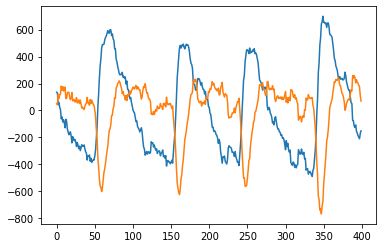

In [9]:
# meanDiffResIR is the filters signal from above minus the unfiltered signal.
# I don't know what the exact intention is. It effectively inverts the signal.
# Maybe that is an unintended side effect which makes the following beat detection actually work...
meanDiffResIR = spo2_mean(data_ir) - data_ir
plt.plot(data_ir[6000:6400])
plt.plot(meanDiffResIR[6000:6400])

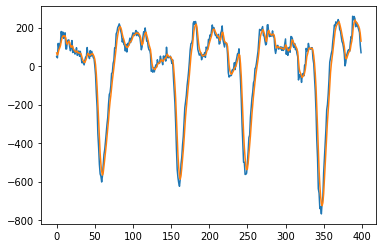

In [10]:
# meanDiffResIR gets filtered once more (apparently using a Butterworth low-pass) removing a lot of noise
def spo2_lowPassButterworthFilter(meanDiffIR):
    v0 = 0
    v1 = 0
    ret = numpy.zeros(len(meanDiffIR))
    for i in range(len(meanDiffIR)):
        v0 = v1
        v1 = 2.452372752527856026e-1 * meanDiffIR[i] + 0.50952544949442879485 * v0
        ret[i] = v0 + v1
    return ret
plt.plot(meanDiffResIR[6000:6400])
lpbFilterIR = spo2_lowPassButterworthFilter(meanDiffResIR)
plt.plot(lpbFilterIR[6000:6400])

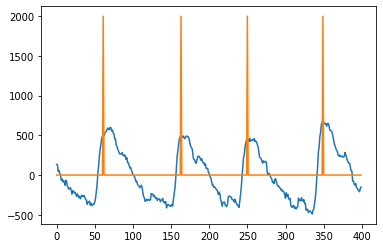

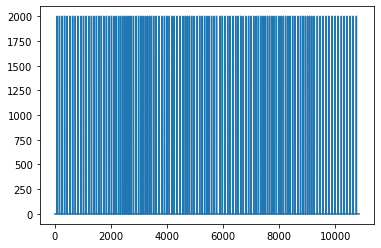

In [11]:
# Final algorithm to detect individual pulses
# We pass -lpbFilterIR as we inverted the whole signal when it was loaded.

def spo2_detectPulse(lpbFilterIR):
    PULSE_MAX_THRESHOLD = 2000
    PULSE_MIN_THRESHOLD = 200
    
    PULSE_IDLE = 0
    PULSE_TRACE_UP = 1
    PULSE_TRACE_DOWN = 2
    
    currentPulseDetectorState = PULSE_IDLE
    prev_sensor_value = 0
    
    ret = numpy.zeros(len(lpbFilterIR))
    for i in range(len(lpbFilterIR)):
        sensor_value = lpbFilterIR[i]
        if sensor_value > PULSE_MAX_THRESHOLD:
            currentPulseDetectorState = PULSE_IDLE
            continue
        if currentPulseDetectorState == PULSE_IDLE:
            if sensor_value >= PULSE_MIN_THRESHOLD:
                currentPulseDetectorState = PULSE_TRACE_UP
        elif currentPulseDetectorState == PULSE_TRACE_UP:
            if sensor_value >= prev_sensor_value:
                pass
            else:
                currentPulseDetectorState = PULSE_TRACE_DOWN
                ret[i] = 2000
        elif currentPulseDetectorState == PULSE_TRACE_DOWN:
            if sensor_value < PULSE_MIN_THRESHOLD:
                currentPulseDetectorState = PULSE_IDLE
        prev_sensor_value = sensor_value;
    return ret

plt.plot(data_ir[6000:6400])
pulses = spo2_detectPulse(-lpbFilterIR)
plt.plot(pulses[6000:6400])
plt.show()

plt.plot(pulses)
plt.show()

## Periodic mesurement reset

The original code resets the SpO2 estimation every 4 beats.
We keep track of these as a data set which is non zero every 4th beat.

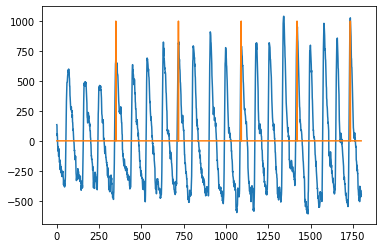

In [12]:
def knock_out_pulses(pulses):
    n = 0
    RESET_SPO2_EVERY_N_PULSES = 4
    ret = numpy.zeros(len(pulses))
    for i in range(len(pulses)):
        if pulses[i]:
            n += 1
            if n == RESET_SPO2_EVERY_N_PULSES:
                n = 0
                ret[i] = 1000
    return ret

                
plt.plot(data_ir[6000:7800])
spo2_resets = knock_out_pulses(pulses)
plt.plot(spo2_resets[6000:7800])

# SpO2 estimation

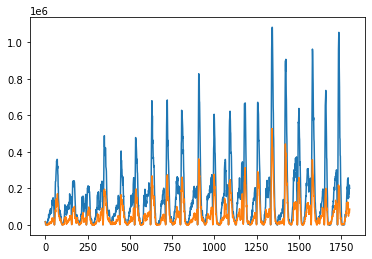

In [13]:
# First: Square the red and infrared signals
data_ir_sq = data_ir * data_ir
data_red_sq = data_red * data_red

plt.plot(data_ir_sq[6000:7800])
plt.plot(data_red_sq[6000:7800])

In [14]:
# Second: Accumulate the values, reseting to 0 every 4th beat
def accumulate_wit_reset(data, reset):
    ret = numpy.zeros(len(data))
    sum = 0
    for i in range(len(data)):
        sum += data[i]
        ret[i] = sum
        if reset[i]:
            sum = 0
    return ret

irACValueSqSum = accumulate_wit_reset(data_ir_sq, spo2_resets)
redACValueSqSum = accumulate_wit_reset(data_red_sq, spo2_resets)

plt.plot(irACValueSqSum[6000:7800])
plt.plot(redACValueSqSum[6000:7800])
plt.plot(pulses[6000:7800]*10000)

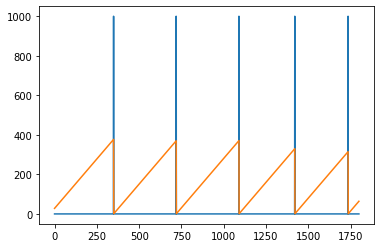

In [15]:
# Third: Create a dataset which indicates how many samples have been accumulated so far.
# Will later be used to calculate an average
samplesRecorded = numpy.zeros(len(spo2_resets))
n = 0
for i in range(len(spo2_resets)):
    n += 1
    samplesRecorded[i] = n
    if(spo2_resets[i]):
        n = 0
plt.plot(spo2_resets[6000:7800])
plt.plot(samplesRecorded[6000:7800])


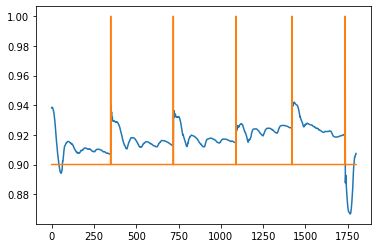

In [16]:
# Fourth: Calculate the RMS ratio (?) between red and infrared
# After each reset, the ratio becomes a bit unstable as very few samples are averaged

ratioRMS = numpy.log(numpy.sqrt(redACValueSqSum/samplesRecorded) ) / numpy.log( numpy.sqrt(irACValueSqSum/samplesRecorded) )
plt.plot(ratioRMS[6000:7800])
plt.plot(spo2_resets[6000:7800]/10000+0.9)


Original comment from TomoStrap:
> This is my adjusted standard model, so it shows 0.89 as 94% saturation. It is probably far from correct, requires proper empircal calibration

In [17]:
currentSaO2Value = 110.0 - 13.6 * ratioRMS

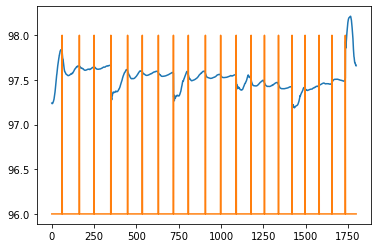

In [18]:
# Plot the values this creates.
# Keep in mind that it becomes unstable every fourth beat due to the reset
plt.plot(currentSaO2Value[6000:7800])
plt.plot(pulses[6000:7800]/1000 + 96)

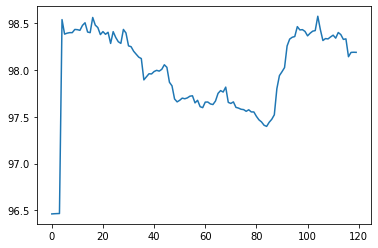

In [19]:
# Plot only the values where a pulse was detected
plt.plot(currentSaO2Value[pulses > 0])

In [20]:
plt.plot(ratioRMS[pulses > 0])

## Conclusion

The majority of this code tries to detect the pulse. This information is used to periodically reset the algorithm and define the sample points.

The actual SpO2 estimation is quite simple. Accumulate the signals, average them, put the result in relation and apply some magic scaling.

Looks like the magic lies within this scaling. More reading to do...

The commercial meter showed values between 88% and 99%. This implementation shows 97.5% to 98.5%.